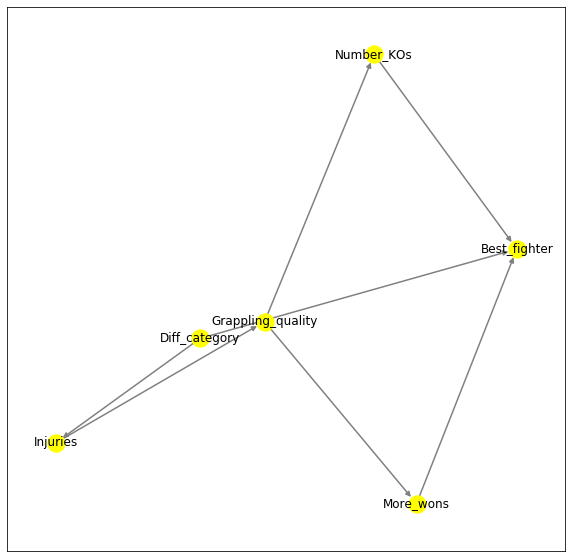

In [1]:
from pgmpy.models import BayesianModel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

model = BayesianModel([('More_wons', 'Best_fighter'),
                       ('Diff_category', 'Best_fighter'),
                       ('Number_KOs', 'Best_fighter'),
                       ('Injuries', 'Grappling_quality'),
                       ('Grappling_quality', 'More_wons'),
                       ('Grappling_quality', 'Number_KOs'),
                       ('Diff_category', 'Injuries')
                       ])

# network nodes and out-edges
nodes = list(model.nodes())
edges = list(model.edges())

DAG = nx.DiGraph()
DAG.add_edges_from(edges)
fig = plt.figure(figsize = (10,10))
pos = nx.spring_layout(DAG) #Position nodes computed by using Fruchterman-Reingold force-directed algorithm.
nx.draw_networkx_nodes(DAG, pos=pos, node_color='yellow')
nx.draw_networkx_labels(DAG, pos=pos)
nx.draw_networkx_edges(DAG, pos=pos, edge_color='gray', width = 1.5, arrows=True)
plt.show()

In [2]:
from pgmpy.factors.discrete import TabularCPD
import numpy as np
# fought on different category
diff_category_cdp = TabularCPD('Diff_category', 2, np.array([[.7,.3]]).T)

# Had injureies
injuries_cpd=TabularCPD('Injuries', 2, [[.70,.3],[.3,.7]],
                       evidence=['Diff_category'],
                       evidence_card=[2])
# Grappling quality
grappling_quality_cpd=TabularCPD('Grappling_quality', 2, [[.7,.4],[.3,.6]],
                       evidence=['Injuries'],
                       evidence_card=[2])
# Has more wons than loses
more_wons_cpd=TabularCPD('More_wons', 2, [[.85,.4],[.15,.6]],
                       evidence=['Grappling_quality'],
                       evidence_card=[2])
# Number of KOs > 5
number_KOs_cpd=TabularCPD('Number_KOs', 2, [[.6,.2],[.4,.8]],
                       evidence=['Grappling_quality'],
                       evidence_card=[2])
# Not chosen/chosen to be the best fighter given Number_KOs, Diff_Category and More_wons
best_fighter_cpd=TabularCPD('Best_fighter',2,[[.95,.73,.7,.23,.35,.20,.28,.1],[.05,.27,.3,.77,.65,.8,.72,.9]],
                       evidence=['Number_KOs','Diff_category','More_wons'],
                       evidence_card=[2,2,2])
model.add_cpds(diff_category_cdp,
               injuries_cpd,
               grappling_quality_cpd,
               more_wons_cpd,
               number_KOs_cpd,
               best_fighter_cpd)

In [3]:
from pgmpy.inference import VariableElimination

exact_inference = VariableElimination(model)

# the prior probability distribution of Best_fighter
query1 = exact_inference.query(['Best_fighter'])
print('\nP(Best_fighter)\n\n', query1)

Eliminating: Grappling_quality: 100%|██████████| 5/5 [00:00<00:00, 425.23it/s]


P(Best_fighter)

 +-----------------+---------------------+
| Best_fighter    |   phi(Best_fighter) |
+=================+=====================+
| Best_fighter(0) |              0.4966 |
+-----------------+---------------------+
| Best_fighter(1) |              0.5034 |
+-----------------+---------------------+


In [4]:
query2 = exact_inference.query(['Best_fighter'],{'Number_KOs':0})
print('\n\nP(Best_fighter|Number_KOs= \"no\" )\n\n', query2)

Eliminating: Grappling_quality: 100%|██████████| 4/4 [00:00<00:00, 464.40it/s]



P(Best_fighter|Number_KOs= "no" )

 +-----------------+---------------------+
| Best_fighter    |   phi(Best_fighter) |
+=================+=====================+
| Best_fighter(0) |              0.8098 |
+-----------------+---------------------+
| Best_fighter(1) |              0.1902 |
+-----------------+---------------------+


In [5]:
query3 = exact_inference.query(['Number_KOs', 'More_wons'], {'Best_fighter':0})
print('\n\nP(Number_KOs, More_wons|Best_fighter= \"no\"" )\n\n', query3)

Eliminating: Grappling_quality: 100%|██████████| 3/3 [00:00<00:00, 532.18it/s]



P(Number_KOs, More_wons|Best_fighter= "no"" )

 +--------------+---------------+-----------------------------+
| More_wons    | Number_KOs    |   phi(More_wons,Number_KOs) |
+==============+===============+=============================+
| More_wons(0) | Number_KOs(0) |                      0.5814 |
+--------------+---------------+-----------------------------+
| More_wons(0) | Number_KOs(1) |                      0.2197 |
+--------------+---------------+-----------------------------+
| More_wons(1) | Number_KOs(0) |                      0.1193 |
+--------------+---------------+-----------------------------+
| More_wons(1) | Number_KOs(1) |                      0.0797 |
+--------------+---------------+-----------------------------+


In [6]:
query4 = exact_inference.map_query(['Best_fighter', 'Number_KOs', 'Diff_category'], {'Grappling_quality':1}) 
print('\n\nMAP of Grappling_quality = \"Good\" \n\n', query4)

Eliminating: More_wons: 100%|██████████| 2/2 [00:00<00:00, 481.88it/s]



MAP of Grappling_quality = "Good" 

 {'Best_fighter': 1, 'Number_KOs': 1, 'Diff_category': 0}


In [7]:
query = exact_inference.query(['Injuries'], {'Diff_category' : 1,'Best_fighter' : 0})
print("\nP(Injuries | Diff_category = \"yes\", Best_fighter = \"no\")\n\n", query)

reference_prob = query.values[1]

Eliminating: Grappling_quality: 100%|██████████| 3/3 [00:00<00:00, 289.46it/s]


P(Injuries | Diff_category = "yes", Best_fighter = "no")

 +-------------+-----------------+
| Injuries    |   phi(Injuries) |
+=============+=================+
| Injuries(0) |          0.3467 |
+-------------+-----------------+
| Injuries(1) |          0.6533 |
+-------------+-----------------+


In [8]:
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
from pgmpy.sampling import GibbsSampling

BMS_inference = BayesianModelSampling(model)
gibbs = GibbsSampling(model)

def get_best_sampling_method(reference_prob, results_WL, results_RS, results_GS):
    wl = abs(reference_prob - results_WL[-1])
    rs = abs(reference_prob - results_RS[-1])
    gs = abs(reference_prob - results_GS[-1])
    if wl < rs and wl < gs:
        print("The best method is WL with a difference wrt the reference value of: {}".format(wl))
    elif rs < wl and rs < gs:
        print("The best method is RS with a difference wrt the reference value of: {}".format(rs))
    else:
        print("The best method is GS with a difference wrt the reference value of: {}".format(gs))

def weighted_likelihood_prob(samples,variable):
    return round(np.sum(np.dot(samples[variable],samples['_weight']))/np.sum(samples['_weight']),2)

def gibbs_sampling(samples):
    return (samples.query('Injuries == 1 & Diff_category == 1 & Best_fighter == 0').shape[0]
                /
            samples.query('Diff_category == 1 & Best_fighter == 0').shape[0])
    
def run(sample_size):
    # Sample
    samples_WL = BMS_inference.likelihood_weighted_sample(
                      evidence = evidence, 
                      size=sample_size, 
                      return_type='recarray')
    samples_RS = BMS_inference.rejection_sample(
                      evidence = evidence, 
                      size=sample_size, 
                      return_type='recarray')
    samples_GS= gibbs.sample(size = size)
    
    # Probability
    results_WL = weighted_likelihood_prob(samples_WL,'Injuries')
    results_RS = np.recarray.mean(samples_RS['Injuries'], axis=0)
    results_GS = gibbs_sampling(samples_GS)
    
    # Return results
    return np.array([(sample_size, 
                      results_WL,
                      results_RS,
                      results_GS)], 
                    dtype=[('sample_size', '<i8'), 
                           ('WL', '<f8'),
                           ('RS', '<f8'),
                           ('GS', '<f8')])

approximate_results = np.array([], dtype=[('sample_size', '<i8'), 
                           ('WL', '<f8'),
                           ('RS', '<f8'),
                           ('GS', '<f8')])
initial_size = 2
final_size = 5
num = 10
evidence = [State('Diff_category',1), State('Best_fighter',0)]

for size in np.logspace(initial_size, final_size, num=num, dtype='<i8'):
    approximate_results=np.append(approximate_results, run(size))
    
sizes = approximate_results['sample_size']
results_WL = approximate_results['WL']
results_RS = approximate_results['RS']
results_GS = approximate_results['GS']

Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 163.68it/s]

Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 119.21it/s]
136it [00:00, 1255.65it/s]             
Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 171.99it/s]

Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 68.27it/s]
331it [00:00, 2415.78it/s]             
Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 132.48it/s]

Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 46.36it/s]
683it [00:00, 3709.27it/s]             
Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 129.57it/s]

Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 27.28it/s]
1514it [00:00, 5392.71it/s]             
Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 70.93it/s]

Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 13.58it/s]
3134it [00:00, 5815

In [9]:
get_best_sampling_method(reference_prob, results_WL, results_RS, results_GS)

The best method is RS with a difference wrt the reference value of: 0.00023334253308904263
